## 第四章 神经网络工具箱nn
上一章中提到，使用autograd可实现深度学习模型，但其抽象程度较低，如果用其来实现深度学习模型，则需要编写的代码量极大。在这种情况下，torch.nn应运而生，其是专门为深度学习而设计的模块。torch.nn的核心数据结构是`Module`，它是一个抽象概念，既可以表示神经网络中的某个层（layer），也可以表示一个包含很多层的神经网络。在实际使用中，最常见的做法是继承`nn.Module`，撰写自己的网络/层。下面先来看看如何用nn.Module实现自己的全连接层。全连接层，又名仿射层，输出$\textbf{y}$和输入$\textbf{x}$满足$\textbf{y=Wx+b}$，$\textbf{W}$和$\textbf{b}$是可学习的参数。

In [6]:
import torch as t
from torch import nn

In [7]:
class Linear(nn.Module): # 继承nn.Module
    def __init__(self, in_features, out_features):
        super(Linear, self).__init__() # 等价于nn.Module.__init__(self)
        self.w = nn.Parameter(t.randn(in_features, out_features))
        self.b = nn.Parameter(t.randn(out_features))
    
    def forward(self, x):
        x = x.mm(self.w) # x.@(self.w)
        return x + self.b.expand_as(x)

In [8]:
layer = Linear(4,3)
input = t.ones(2,4)
print(input)
output = layer(input)
print(output)

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.]])
tensor([[1.5746, 5.2399, 1.1130],
        [1.5746, 5.2399, 1.1130]], grad_fn=<AddBackward0>)


In [4]:
t.randn(4,3)

tensor([[ 1.2154, -0.1399, -0.6054],
        [-0.0923, -0.8450, -0.5548],
        [ 0.2367, -0.2654,  0.1127],
        [-0.4231,  0.6504, -1.2657]])

In [5]:
for name, parameter in layer.named_parameters():
    print(name, parameter) # w and b 

w Parameter containing:
tensor([[-0.6079,  0.0112, -0.4793],
        [-0.6101, -0.7928,  0.0519],
        [ 0.7047, -1.4950, -0.6205],
        [ 1.5292,  0.8183,  1.7122]], requires_grad=True)
b Parameter containing:
tensor([ 1.0787, -1.4748, -0.9762], requires_grad=True)


可见，全连接层的实现非常简单，其代码量不超过10行，但需注意以下几点：
- 自定义层`Linear`必须继承`nn.Module`，并且在其构造函数中需调用`nn.Module`的构造函数，即`super(Linear, self).__init__()` 或`nn.Module.__init__(self)`，推荐使用第一种用法，尽管第二种写法更直观。
- 在构造函数`__init__`中必须自己定义可学习的参数，并封装成`Parameter`，如在本例中我们把`w`和`b`封装成`parameter`。`parameter`是一种特殊的`Tensor`，但其默认需要求导（requires_grad = True），感兴趣的读者可以通过`nn.Parameter??`，查看`Parameter`类的源代码。
- `forward`函数实现前向传播过程，其输入可以是一个或多个tensor。
- 无需写反向传播函数，nn.Module能够利用autograd自动实现反向传播，这点比Function简单许多。
- 使用时，直观上可将layer看成数学概念中的函数，调用layer(input)即可得到input对应的结果。它等价于`layers.__call__(input)`，在`__call__`函数中，主要调用的是 `layer.forward(x)`，另外还对钩子做了一些处理。所以在实际使用中应尽量使用`layer(x)`而不是使用`layer.forward(x)`，关于钩子技术将在下文讲解。
- `Module`中的可学习参数可以通过`named_parameters()`或者`parameters()`返回迭代器，前者会给每个parameter都附上名字，使其更具有辨识度。

可见利用Module实现的全连接层，比利用`Function`实现的更为简单，因其不再需要写反向传播函数。

Module能够自动检测到自己的`Parameter`，并将其作为学习参数。除了`parameter`之外，Module还包含子`Module`，主Module能够递归查找子`Module`中的`parameter`。下面再来看看稍微复杂一点的网络，多层感知机。

多层感知机的网络结构如图4-1所示，它由两个全连接层组成，采用$sigmoid$函数作为激活函数，图中没有画出。
![图4-1；多层感知机](imgs/multi_perceptron.png)

In [10]:
class Perceptron(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        nn.Module.__init__(self)
        self.layer1 = Linear(in_features, hidden_features) # 此处的Linear是前面自定义的全连接层
        self.layer2 = Linear(hidden_features, hidden_features)
        self.layer3 = Linear(hidden_features, out_features)
    def forward(self,x):
        x = self.layer1(x)
        x = t.sigmoid(x)
        return self.layer2(x)

In [11]:
perceptron = Perceptron(3,4,1)
for name, param in perceptron.named_parameters():
    print(name, param.size())

layer1.w torch.Size([3, 4])
layer1.b torch.Size([4])
layer2.w torch.Size([4, 4])
layer2.b torch.Size([4])
layer3.w torch.Size([4, 1])
layer3.b torch.Size([1])


可见，即使是稍复杂的多层感知机，其实现依旧很简单。 构造函数`__init__`中，可利用前面自定义的Linear层(module)，作为当前module对象的一个子module，它的可学习参数，也会成为当前module的可学习参数。

module中parameter的命名规范：
- 对于类似`self.param_name = nn.Parameter(t.randn(3, 4))`，命名为`param_name`
- 对于子Module中的parameter，会其名字之前加上当前Module的名字。如对于`self.sub_module = SubModel()`，SubModel中有个parameter的名字叫做param_name，那么二者拼接而成的parameter name 就是`sub_module.param_name`。

为方便用户使用，PyTorch实现了神经网络中绝大多数的layer，这些layer都继承于nn.Module，封装了可学习参数`parameter`，并实现了forward函数，且很多都专门针对GPU运算进行了CuDNN优化，其速度和性能都十分优异。本书不准备对nn.Module中的所有层进行详细介绍，具体内容读者可参照官方文档[^1]或在IPython/Jupyter中使用nn.layer?来查看。阅读文档时应主要关注以下几点：

- 构造函数的参数，如nn.Linear(in_features, out_features, bias)，需关注这三个参数的作用。
- 属性、可学习参数和子module。如nn.Linear中有`weight`和`bias`两个可学习参数，不包含子module。
- 输入输出的形状，如nn.linear的输入形状是(N, input_features)，输出为(N，output_features)，N是batch_size。

这些自定义layer对输入形状都有假设：输入的不是单个数据，而是一个batch。输入只有一个数据，则必须调用`tensor.unsqueeze(0)` 或 `tensor[None]`将数据伪装成batch_size=1的batch

[^1]: http://pytorch.org/docs/nn.html

下面将从应用层面出发，对一些常用的layer做简单介绍，更详细的用法请查看文档，这里只作概览参考。

### 4.1 常用神经网络层
#### 4.1.1 图像相关层

图像相关层主要包括卷积层（Conv）、池化层（Pool）等，这些层在实际使用中可分为一维(1D)、二维(2D)、三维（3D），池化方式又分为平均池化（AvgPool）、最大值池化（MaxPool）、自适应池化（AdaptiveAvgPool）等。而卷积层除了常用的前向卷积之外，还有逆卷积（TransposeConv）。下面举例说明一些基础的使用。

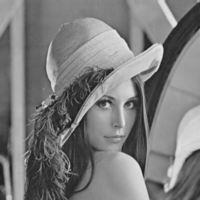

In [12]:
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage
to_tensor = ToTensor() # img -> tensor
to_pil = ToPILImage()
lena = Image.open('imgs/lena.png')
lena

tensor([[0.5000, 0.0000, 0.0000],
        [0.0000, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.5000]])


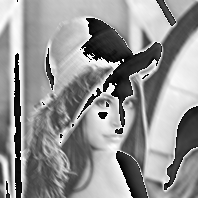

In [14]:
# 输入是一个batch，batch_size＝1
input = to_tensor(lena).unsqueeze(0) 

# 锐化卷积核
kernel = t.eye(3, 3)/2
print(kernel)
kernel[1][1] = 0.5
conv = nn.Conv2d(1, 1, (3, 3), 1, bias=False)
conv.weight.data = kernel.view(1, 1, 3, 3)

out = conv(input)
to_pil(out.data.squeeze(0))

除了上述的使用，图像的卷积操作还有各种变体，具体可以参照此处动图[^2]介绍。
[^2]: https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md

池化层可以看作是一种特殊的卷积层，用来下采样。但池化层没有可学习参数，其weight是固定的。

In [15]:
pool = nn.AvgPool2d(2,2)
list(pool.parameters())

[]

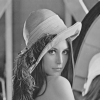

In [17]:
out = pool(input)
to_pil(out.data.squeeze(0))

除了卷积层和池化层，深度学习中还将常用到以下几个层：
- Linear：全连接层。
- BatchNorm：批规范化层，分为1D、2D和3D。除了标准的BatchNorm之外，还有在风格迁移中常用到的InstanceNorm层。
- Dropout：dropout层，用来防止过拟合，同样分为1D、2D和3D。
下面通过例子来说明它们的使用。

In [18]:
# 输入 batch_size=2，维度3
input = t.randn(2, 3)
linear = nn.Linear(3, 4)
h = linear(input)
h

tensor([[-0.3667,  0.0423, -0.1047,  0.5234],
        [-0.9013,  0.3646, -0.0995,  1.2344]], grad_fn=<AddmmBackward>)

In [19]:
# 4 channel，初始化标准差为4，均值为0
bn = nn.BatchNorm1d(4)
bn.weight.data = t.ones(4) * 4
bn.bias.data = t.zeros(4)

bn_out = bn(h)
# 注意输出的均值和方差
# 方差是标准差的平方，计算无偏方差分母会减1
# 使用unbiased=False 分母不减1
bn_out.mean(0), bn_out.var(0, unbiased=False)

(tensor([-4.7684e-07,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        grad_fn=<MeanBackward1>),
 tensor([15.9978, 15.9938,  6.3893, 15.9987], grad_fn=<VarBackward1>))

In [20]:
# 每个元素以0.5的概率舍弃
dropout = nn.Dropout(0.5)
o = dropout(bn_out)
o # 有一半左右的数变为0

tensor([[ 0.0000, -7.9985, -0.0000, -7.9997],
        [-0.0000,  7.9985,  0.0000,  7.9997]], grad_fn=<MulBackward0>)

以上很多例子中都对module的属性直接操作，其大多数是可学习参数，一般会随着学习的进行而不断改变。实际使用中除非需要使用特殊的初始化，应尽量不要直接修改这些参数。

#### 4.1.2 激活函数
PyTorch实现了常见的激活函数，其具体的接口信息可参见官方文档[^3]，这些激活函数可作为独立的layer使用。这里将介绍最常用的激活函数ReLU，其数学表达式为：
$$ReLU(x)=max(0,x)$$
[^3]: http://pytorch.org/docs/nn.html#non-linear-activations

In [21]:
relu = nn.ReLU(inplace=True)
input = t.randn(2, 3)
print(input)
output = relu(input)
print(output) # 小于0的都被截断为0
# 等价于input.clamp(min=0)

tensor([[-0.2012,  0.2375, -1.6199],
        [ 1.1911,  0.0887,  0.1204]])
tensor([[0.0000, 0.2375, 0.0000],
        [1.1911, 0.0887, 0.1204]])


在以上的例子中，基本上都是将每一层的输出直接作为下一层的输入，这种网络称为前馈传播网络（feedforward neural network）。对于此类网络如果每次都写复杂的forward函数会有些麻烦，在此就有两种简化方式，ModuleList和Sequential。其中Sequential是一个特殊的module，它包含几个子Module，前向传播时会将输入一层接一层的传递下去。ModuleList也是一个特殊的module，可以包含几个子module，可以像用list一样使用它，但不能直接把输入传给ModuleList。下面举例说明。

In [23]:
# Sequential的三种写法
net1 = nn.Sequential()
net1.add_module('conv', nn.Conv2d(3, 3, 3))
net1.add_module('batchnorm', nn.BatchNorm2d(3))
net1.add_module('activation_layer', nn.ReLU())

net2 = nn.Sequential(
        nn.Conv2d(3, 3, 3),
        nn.BatchNorm2d(3),
        nn.ReLU()
        )

from collections import OrderedDict
net3= nn.Sequential(OrderedDict([
          ('conv1', nn.Conv2d(3, 3, 3)),
          ('bn1', nn.BatchNorm2d(3)),
          ('relu1', nn.ReLU())
        ]))
print('net1:', net1)
print('net2:', net2)
print('net3:', net3)

net1: Sequential(
  (conv): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation_layer): ReLU()
)
net2: Sequential(
  (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)
net3: Sequential(
  (conv1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
)


In [ ]:
# 可根据名字或序号取出子module
net1.conv, net2[0], net3.conv1

In [24]:
input = t.rand(1, 3, 4, 4)
output = net1(input)
output = net2(input)
output = net3(input)
output = net3.relu1(net1.batchnorm(net1.conv(input)))

In [ ]:
modellist = nn.ModuleList([nn.Linear(3,4), nn.ReLU(), nn.Linear(4,2)])
input = t.randn(1, 3)
for model in modellist:
    input = model(input)
# 下面会报错,因为modellist没有实现forward方法
# output = modelist(input)

看到这里，读者可能会问，为何不直接使用Python中自带的list，而非要多此一举呢？这是因为`ModuleList`是`Module`的子类，当在`Module`中使用它的时候，就能自动识别为子module。

下面举例说明。

In [27]:
class MyModule(nn.Module):
    def __init__(self):
        super(MyModule, self).__init__()
        self.list = [nn.Linear(3, 4), nn.ReLU()]#这个不能识别
        self.module_list = nn.ModuleList([nn.Conv2d(3, 3, 3), nn.ReLU()])
    def forward(self):
        pass
model = MyModule()
model

MyModule(
  (module_list): ModuleList(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
)

In [28]:
for name, param in model.named_parameters():
    print(name, param.size())

module_list.0.weight torch.Size([3, 3, 3, 3])
module_list.0.bias torch.Size([3])


可见，list中的子module并不能被主module所识别，而ModuleList中的子module能够被主module所识别。这意味着如果用list保存子module，将无法调整其参数，因其未加入到主module的参数中。

除ModuleList之外还有ParameterList，其是一个可以包含多个parameter的类list对象。在实际应用中，使用方式与ModuleList类似。如果在构造函数`__init__`中用到list、tuple、dict等对象时，一定要思考是否应该用ModuleList或ParameterList代替。

#### 4.1.3 循环神经网络层(RNN)
近些年随着深度学习和自然语言处理的结合加深，RNN的使用也越来越多，关于RNN的基础知识，推荐阅读colah的文章[^4]入门。PyTorch中实现了如今最常用的三种RNN：RNN（vanilla RNN）、LSTM和GRU。此外还有对应的三种RNNCell。

RNN和RNNCell层的区别在于前者一次能够处理整个序列，而后者一次只处理序列中一个时间点的数据，前者封装更完备更易于使用，后者更具灵活性。实际上RNN层的一种后端实现方式就是调用RNNCell来实现的。
[^4]: http://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [34]:
t.manual_seed(1000)
# 输入：batch_size=3，序列长度都为2，序列中每个元素占4维
input = t.randn(2, 3, 4)
# lstm输入向量4维，隐藏元3，1层
lstm = nn.LSTM(4, 3, 1)
# 初始状态：1层，batch_size=3，3个隐藏元
h0 = t.randn(1, 3, 3)
c0 = t.randn(1, 3, 3)
out, hn = lstm(input, (h0, c0))
out

tensor([[[-0.3610, -0.1643,  0.1631],
         [-0.0613, -0.4937, -0.1642],
         [ 0.5080, -0.4175,  0.2502]],

        [[-0.0703, -0.0393, -0.0429],
         [ 0.2085, -0.3005, -0.2686],
         [ 0.1482, -0.4728,  0.1425]]], grad_fn=<StackBackward>)

In [33]:
t.manual_seed(1000)
input = t.randn(2, 3, 4)
# 一个LSTMCell对应的层数只能是一层
lstm = nn.LSTMCell(4, 3)
hx = t.randn(3, 3)
cx = t.randn(3, 3)
out = []
for i_ in input:
    hx, cx=lstm(i_, (hx, cx))
    out.append(hx)
t.stack(out)

tensor([[[-0.3610, -0.1643,  0.1631],
         [-0.0613, -0.4937, -0.1642],
         [ 0.5080, -0.4175,  0.2502]],

        [[-0.0703, -0.0393, -0.0429],
         [ 0.2085, -0.3005, -0.2686],
         [ 0.1482, -0.4728,  0.1425]]], grad_fn=<StackBackward>)

词向量在自然语言中应用十分普及，PyTorch同样提供了Embedding层。

In [36]:
# 有4个词，每个词用5维的向量表示
embedding = nn.Embedding(4, 5)
# 可以用预训练好的词向量初始化embedding
embedding.weight.data = t.arange(0,20).view(4,5)

In [35]:
input = t.arange(3, 0, -1).long()
output = embedding(input)
output

RuntimeError: isDifferentiableType(variable.scalar_type()) INTERNAL ASSERT FAILED at "..\\torch/csrc/autograd/functions/utils.h":64, please report a bug to PyTorch. 

#### 4.1.4 损失函数
在深度学习中要用到各种各样的损失函数（loss function），这些损失函数可看作是一种特殊的layer，PyTorch也将这些损失函数实现为`nn.Module`的子类。然而在实际使用中通常将这些loss function专门提取出来，和主模型互相独立。详细的loss使用请参照文档[^5]，这里以分类中最常用的交叉熵损失CrossEntropyloss为例说明。
[^5]: http://pytorch.org/docs/nn.html#loss-functions

In [ ]:
# batch_size=3，计算对应每个类别的分数（只有两个类别）
score = t.randn(3, 2)
# 三个样本分别属于1，0，1类，label必须是LongTensor
label = t.Tensor([1, 0, 1]).long()

# loss与普通的layer无差异
criterion = nn.CrossEntropyLoss()
loss = criterion(score, label)
loss

### 4.2 优化器

PyTorch将深度学习中常用的优化方法全部封装在`torch.optim`中，其设计十分灵活，能够很方便的扩展成自定义的优化方法。

所有的优化方法都是继承基类`optim.Optimizer`，并实现了自己的优化步骤。下面就以最基本的优化方法——随机梯度下降法（SGD）举例说明。这里需重点掌握：

- 优化方法的基本使用方法
- 如何对模型的不同部分设置不同的学习率
- 如何调整学习率

In [45]:
# 首先定义一个LeNet网络
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.features = nn.Sequential(
                    nn.Conv2d(3, 6, 5),
                    nn.ReLU(),
                    nn.MaxPool2d(2,2),
                    nn.Conv2d(6, 16, 5),
                    nn.ReLU(),
                    nn.MaxPool2d(2,2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 16 * 5 * 5)
        x = self.classifier(x)
        return x

net = Net()

In [46]:
net.parameters

<bound method Module.parameters of Net(
  (features): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)>

In [47]:
from torch import  optim
optimizer = optim.SGD(params=net.parameters(), lr=1)
optimizer.zero_grad() # 梯度清零，等价于net.zero_grad()

input = t.randn(1, 3, 32, 32)
output = net(input)
output.backward(output) # fake backward

optimizer.step() # 执行优化

In [42]:
# 为不同子网络设置不同的学习率，在finetune中经常用到
# 如果对某个参数不指定学习率，就使用最外层的默认学习率
optimizer =optim.SGD([
                {'params': net.features.parameters()}, # 学习率为1e-5
                {'params': net.classifier.parameters(), 'lr': 1e-2}
            ], lr=1e-5)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 1e-05
    momentum: 0
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [48]:
# 只为两个全连接层设置较大的学习率，其余层的学习率较小
special_layers = nn.ModuleList([net.classifier[0], net.classifier[3]])
special_layers_params = list(map(id, special_layers.parameters()))
base_params = filter(lambda p: id(p) not in special_layers_params,
                     net.parameters())

optimizer = t.optim.SGD([
            {'params': base_params},
            {'params': special_layers.parameters(), 'lr': 0.01}
        ], lr=0.001 )
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0
)

对于如何调整学习率，主要有两种做法。一种是修改optimizer.param_groups中对应的学习率，另一种是更简单也是较为推荐的做法——新建优化器，由于optimizer十分轻量级，构建开销很小，故而可以构建新的optimizer。但是后者对于使用动量的优化器（如Adam），会丢失动量等状态信息，可能会造成损失函数的收敛出现震荡等情况。

In [49]:
# 方法1: 调整学习率，新建一个optimizer
old_lr = 0.1
optimizer1 =optim.SGD([
                {'params': net.features.parameters()},
                {'params': net.classifier.parameters(), 'lr': old_lr*0.1}
            ], lr=1e-5)
optimizer1

SGD (
Parameter Group 0
    dampening: 0
    lr: 1e-05
    momentum: 0
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    lr: 0.010000000000000002
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [50]:
# 方法2: 调整学习率, 手动decay, 保存动量
for param_group in optimizer.param_groups:
    param_group['lr'] *= 0.1 # 学习率为之前的0.1倍
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.0001
    momentum: 0
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    lr: 0.001
    momentum: 0
    nesterov: False
    weight_decay: 0
)

### 4.3 nn.functional

nn中还有一个很常用的模块：`nn.functional`，nn中的大多数layer，在`functional`中都有一个与之相对应的函数。`nn.functional`中的函数和`nn.Module`的主要区别在于，用nn.Module实现的layers是一个特殊的类，都是由`class layer(nn.Module)`定义，会自动提取可学习的参数。而`nn.functional`中的函数更像是纯函数，由`def function(input)`定义。下面举例说明functional的使用，并指出二者的不同之处。

In [53]:
input = t.randn(2, 3)
model = nn.Linear(3, 4)
output1 = model(input)
output2 = nn.functional.linear(input, model.weight, model.bias)
output1 == output2
print(output1)

tensor([[ 0.0745,  0.0210, -0.5132, -0.2994],
        [ 0.1001, -1.0692,  0.1828,  0.1031]], grad_fn=<AddmmBackward>)


In [ ]:
b = nn.functional.relu(input)
b2 = nn.ReLU()(input)
b == b2

此时读者可能会问，应该什么时候使用nn.Module，什么时候使用nn.functional呢？答案很简单，如果模型有可学习的参数，最好用nn.Module，否则既可以使用nn.functional也可以使用nn.Module，二者在性能上没有太大差异，具体的使用取决于个人的喜好。如激活函数（ReLU、sigmoid、tanh），池化（MaxPool）等层由于没有可学习参数，则可以使用对应的functional函数代替，而对于卷积、全连接等具有可学习参数的网络建议使用nn.Module。下面举例说明，如何在模型中搭配使用nn.Module和nn.functional。另外虽然dropout操作也没有可学习操作，但建议还是使用`nn.Dropout`而不是`nn.functional.dropout`，因为dropout在训练和测试两个阶段的行为有所差别，使用`nn.Module`对象能够通过`model.eval`操作加以区分。

In [54]:
from torch.nn import functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.pool(F.relu(self.conv1(x)), 2)
        x = F.pool(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

对于不具备可学习参数的层（激活层、池化层等），将它们用函数代替，这样则可以不用放置在构造函数`__init__`中。对于有可学习参数的模块，也可以用functional来代替，只不过实现起来较为繁琐，需要手动定义参数parameter，如前面实现自定义的全连接层，就可将weight和bias两个参数单独拿出来，在构造函数中初始化为parameter。

In [55]:
class MyLinear(nn.Module):
    def __init__(self):
        super(MyLinear, self).__init__()
        self.weight = nn.Parameter(t.randn(3, 4))
        self.bias = nn.Parameter(t.zeros(3))
    def forward(self):
        return F.linear(input, weight, bias)

关于nn.functional的设计初衷，以及它和nn.Module更多的比较说明，可参看论坛的讨论和作者说明[^6]。
[^6]: https://discuss.pytorch.org/search?q=nn.functional

### 4.4 初始化策略
在深度学习中参数的初始化十分重要，良好的初始化能让模型更快收敛，并达到更高水平，而糟糕的初始化则可能使得模型迅速瘫痪。PyTorch中nn.Module的模块参数都采取了较为合理的初始化策略，因此一般不用我们考虑，当然我们也可以用自定义初始化去代替系统的默认初始化。而当我们在使用Parameter时，自定义初始化则尤为重要，因t.Tensor()返回的是内存中的随机数，很可能会有极大值，这在实际训练网络中会造成溢出或者梯度消失。PyTorch中`nn.init`模块就是专门为初始化而设计，如果某种初始化策略`nn.init`不提供，用户也可以自己直接初始化。

In [57]:
# 利用nn.init初始化
from torch.nn import init
linear = nn.Linear(3, 4)

t.manual_seed(1)
# 等价于 linear.weight.data.normal_(0, std)
init.xavier_normal_(linear.weight)

Parameter containing:
tensor([[ 0.3535,  0.1427,  0.0330],
        [ 0.3321, -0.2416, -0.0888],
        [-0.8140,  0.2040, -0.5493],
        [-0.3010, -0.4769, -0.0311]], requires_grad=True)

In [58]:
# 直接初始化
import math
t.manual_seed(1)

# xavier初始化的计算公式
std = math.sqrt(2)/math.sqrt(7.)
linear.weight.data.normal_(0,std)

tensor([[ 0.3535,  0.1427,  0.0330],
        [ 0.3321, -0.2416, -0.0888],
        [-0.8140,  0.2040, -0.5493],
        [-0.3010, -0.4769, -0.0311]])

In [59]:
# 对模型的所有参数进行初始化
for name, params in net.named_parameters():
    if name.find('linear') != -1:
        # init linear
        params[0] # weight
        params[1] # bias
    elif name.find('conv') != -1:
        pass
    elif name.find('norm') != -1:
        pass

### 4.5 nn.Module深入分析

如果想要更深入地理解nn.Module，究其原理是很有必要的。首先来看看nn.Module基类的构造函数：
```python
def __init__(self):
    self._parameters = OrderedDict()
    self._modules = OrderedDict()
    self._buffers = OrderedDict()
    self._backward_hooks = OrderedDict()
    self._forward_hooks = OrderedDict()
    self.training = True
```
其中每个属性的解释如下：

- `_parameters`：字典，保存用户直接设置的parameter，`self.param1 = nn.Parameter(t.randn(3, 3))`会被检测到，在字典中加入一个key为'param'，value为对应parameter的item。而self.submodule = nn.Linear(3, 4)中的parameter则不会存于此。
- `_modules`：子module，通过`self.submodel = nn.Linear(3, 4)`指定的子module会保存于此。
- `_buffers`：缓存。如batchnorm使用momentum机制，每次前向传播需用到上一次前向传播的结果。
- `_backward_hooks`与`_forward_hooks`：钩子技术，用来提取中间变量，类似variable的hook。
- `training`：BatchNorm与Dropout层在训练阶段和测试阶段中采取的策略不同，通过判断training值来决定前向传播策略。

上述几个属性中，`_parameters`、`_modules`和`_buffers`这三个字典中的键值，都可以通过`self.key`方式获得，效果等价于`self._parameters['key']`.

下面举例说明。

In [60]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 等价与self.register_parameter('param1' ,nn.Parameter(t.randn(3, 3)))
        self.param1 = nn.Parameter(t.rand(3, 3))
        self.submodel1 = nn.Linear(3, 4) 
    def forward(self, input):
        x = self.param1.mm(input)
        x = self.submodel1(x)
        return x
net = Net()
net

Net(
  (submodel1): Linear(in_features=3, out_features=4, bias=True)
)

In [61]:
net._modules

OrderedDict([('submodel1', Linear(in_features=3, out_features=4, bias=True))])

In [62]:
net._parameters

OrderedDict([('param1',
              Parameter containing:
              tensor([[0.3398, 0.5239, 0.7981],
                      [0.7718, 0.0112, 0.8100],
                      [0.6397, 0.9743, 0.8300]], requires_grad=True))])

In [63]:
net.param1 # 等价于net._parameters['param1']

Parameter containing:
tensor([[0.3398, 0.5239, 0.7981],
        [0.7718, 0.0112, 0.8100],
        [0.6397, 0.9743, 0.8300]], requires_grad=True)

In [64]:
for name, param in net.named_parameters():
    print(name, param.size())

param1 torch.Size([3, 3])
submodel1.weight torch.Size([4, 3])
submodel1.bias torch.Size([4])


In [65]:
for name, submodel in net.named_modules():
    print(name, submodel)

 Net(
  (submodel1): Linear(in_features=3, out_features=4, bias=True)
)
submodel1 Linear(in_features=3, out_features=4, bias=True)


In [69]:
bn = nn.BatchNorm1d(2)
input = t.rand(3, 2)
output = bn(input)
bn._buffers

OrderedDict([('running_mean', tensor([0.0549, 0.0595])),
             ('running_var', tensor([0.9117, 0.9131])),
             ('num_batches_tracked', tensor(1))])

nn.Module在实际使用中可能层层嵌套，一个module包含若干个子module，每一个子module又包含了更多的子module。为方便用户访问各个子module，nn.Module实现了很多方法，如函数`children`可以查看直接子module，函数`module`可以查看所有的子module（包括当前module）。与之相对应的还有函数`named_childen`和`named_modules`，其能够在返回module列表的同时返回它们的名字。

In [74]:
input = t.arange(0, 12).view(3, 4)/2.0
print(input)
model = nn.Dropout()
# 在训练阶段，会有一半左右的数被随机置为0
model(input)

tensor([[0.0000, 0.5000, 1.0000, 1.5000],
        [2.0000, 2.5000, 3.0000, 3.5000],
        [4.0000, 4.5000, 5.0000, 5.5000]])


tensor([[ 0.,  0.,  0.,  3.],
        [ 4.,  0.,  0.,  7.],
        [ 8.,  9., 10., 11.]])

In [72]:
model.training  = False
# 在测试阶段，dropout什么都不做
model(input)

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])

对于batchnorm、dropout、instancenorm等在训练和测试阶段行为差距巨大的层，如果在测试时不将其training值设为True，则可能会有很大影响，这在实际使用中要千万注意。虽然可通过直接设置`training`属性，来将子module设为train和eval模式，但这种方式较为繁琐，因如果一个模型具有多个dropout层，就需要为每个dropout层指定training属性。更为推荐的做法是调用`model.train()`函数，它会将当前module及其子module中的所有training属性都设为True，相应的，`model.eval()`函数会把training属性都设为False。

In [ ]:
print(net.training, net.submodel1.training)
net.eval()
net.training, net.submodel1.training

In [ ]:
list(net.named_modules())

`register_forward_hook`与`register_backward_hook`，这两个函数的功能类似于variable函数的`register_hook`，可在module前向传播或反向传播时注册钩子。每次前向传播执行结束后会执行钩子函数（hook）。前向传播的钩子函数具有如下形式：`hook(module, input, output) -> None`，而反向传播则具有如下形式：`hook(module, grad_input, grad_output) -> Tensor or None`。钩子函数不应修改输入和输出，并且在使用后应及时删除，以避免每次都运行钩子增加运行负载。钩子函数主要用在获取某些中间结果的情景，如中间某一层的输出或某一层的梯度。这些结果本应写在forward函数中，但如果在forward函数中专门加上这些处理，可能会使处理逻辑比较复杂，这时候使用钩子技术就更合适一些。下面考虑一种场景，有一个预训练好的模型，需要提取模型的某一层（不是最后一层）的输出作为特征进行分类，但又不希望修改其原有的模型定义文件，这时就可以利用钩子函数。下面给出实现的伪代码。
```python
model = VGG()
features = t.Tensor()
def hook(module, input, output):
    '''把这层的输出拷贝到features中'''
    features.copy_(output.data)
    
handle = model.layer8.register_forward_hook(hook)
_ = model(input)
# 用完hook后删除
handle.remove()
```

`nn.Module`对象在构造函数中的行为看起来有些怪异，如果想要真正掌握其原理，就需要看两个魔法方法`__getattr__`和`__setattr__`。在Python中有两个常用的buildin方法`getattr`和`setattr`，`getattr(obj, 'attr1')`等价于`obj.attr`，如果`getattr`函数无法找到所需属性，Python会转而调用`obj.__getattr__('attr1')`方法，即`getattr`函数无法找到的交给`__getattr__`函数处理，没有实现`__getattr__`或者`__getattr__`也无法处理的就会raise AttributeError。`setattr(obj, 'name', value)`等价于`obj.name=value`，如果obj对象实现了`__setattr__`方法，setattr会直接调用`obj.__setattr__('name', value)`，否则调用buildin方法。总结一下：
- result  = obj.name会调用buildin函数`getattr(obj, 'name')`，如果该属性找不到，会调用`obj.__getattr__('name')`
- obj.name = value会调用buildin函数`setattr(obj, 'name', value)`，如果obj对象实现了`__setattr__`方法，`setattr`会直接调用`obj.__setattr__('name', value')`

nn.Module实现了自定义的`__setattr__`函数，当执行`module.name=value`时，会在`__setattr__`中判断value是否为`Parameter`或`nn.Module`对象，如果是则将这些对象加到`_parameters`和`_modules`两个字典中，而如果是其它类型的对象，如`Variable`、`list`、`dict`等，则调用默认的操作，将这个值保存在`__dict__`中。

In [ ]:
module = nn.Module()
module.param = nn.Parameter(t.ones(2, 2))
module._parameters

In [ ]:
submodule1 = nn.Linear(2, 2)
submodule2 = nn.Linear(2, 2)
module_list =  [submodule1, submodule2]
# 对于list对象，调用buildin函数，保存在__dict__中
module.submodules = module_list
print('_modules: ', module._modules)
print("__dict__['submodules']:",module.__dict__.get('submodules'))

In [ ]:
module_list = nn.ModuleList(module_list)
module.submodules = module_list
print('ModuleList is instance of nn.Module: ', isinstance(module_list, nn.Module))
print('_modules: ', module._modules)
print("__dict__['submodules']:", module.__dict__.get('submodules'))

因`_modules`和`_parameters`中的item未保存在`__dict__`中，所以默认的getattr方法无法获取它，因而`nn.Module`实现了自定义的`__getattr__`方法，如果默认的`getattr`无法处理，就调用自定义的`__getattr__`方法，尝试从`_modules`、`_parameters`和`_buffers`这三个字典中获取。

In [ ]:
getattr(module, 'training') # 等价于module.training
# error
# module.__getattr__('training')

In [ ]:
module.attr1 = 2
getattr(module, 'attr1')
# 报错
# module.__getattr__('attr1')

In [ ]:
# 即module.param, 会调用module.__getattr__('param')
getattr(module, 'param')

在PyTorch中保存模型十分简单，所有的Module对象都具有state_dict()函数，返回当前Module所有的状态数据。将这些状态数据保存后，下次使用模型时即可利用`model.load_state_dict()`函数将状态加载进来。优化器（optimizer）也有类似的机制，不过一般并不需要保存优化器的运行状态。

In [ ]:
# 保存模型
t.save(net.state_dict(), 'net.pth')

# 加载已保存的模型
net2 = Net()
net2.load_state_dict(t.load('net.pth'))

实际上还有另外一种保存方法，但因其严重依赖模型定义方式及文件路径结构等，很容易出问题，因而不建议使用。

In [ ]:
t.save(net, 'net_all.pth')
net2 = t.load('net_all.pth')
net2

将Module放在GPU上运行也十分简单，只需两步：
- model = model.cuda()：将模型的所有参数转存到GPU
- input.cuda()：将输入数据也放置到GPU上

至于如何在多个GPU上并行计算，PyTorch也提供了两个函数，可实现简单高效的并行GPU计算
- nn.parallel.data_parallel(module, inputs, device_ids=None, output_device=None, dim=0, module_kwargs=None)
- class torch.nn.DataParallel(module, device_ids=None, output_device=None, dim=0)

可见二者的参数十分相似，通过`device_ids`参数可以指定在哪些GPU上进行优化，output_device指定输出到哪个GPU上。唯一的不同就在于前者直接利用多GPU并行计算得出结果，而后者则返回一个新的module，能够自动在多GPU上进行并行加速。

```
# method 1
new_net = nn.DataParallel(net, device_ids=[0, 1])
output = new_net(input)

# method 2
output = nn.parallel.data_parallel(new_net, input, device_ids=[0, 1])
```

DataParallel并行的方式，是将输入一个batch的数据均分成多份，分别送到对应的GPU进行计算，各个GPU得到的梯度累加。与Module相关的所有数据也都会以浅复制的方式复制多份，在此需要注意，在module中属性应该是只读的。

### 4.6 nn和autograd的关系
nn.Module利用的也是autograd技术，其主要工作是实现前向传播。在forward函数中，nn.Module对输入的tensor进行的各种操作，本质上都是用到了autograd技术。这里需要对比autograd.Function和nn.Module之间的区别：
- autograd.Function利用了Tensor对autograd技术的扩展，为autograd实现了新的运算op，不仅要实现前向传播还要手动实现反向传播
- nn.Module利用了autograd技术，对nn的功能进行扩展，实现了深度学习中更多的层。只需实现前向传播功能，autograd即会自动实现反向传播
- nn.functional是一些autograd操作的集合，是经过封装的函数

作为两大类扩充PyTorch接口的方法，我们在实际使用中应该如何选择呢？如果某一个操作，在autograd中尚未支持，那么只能实现Function接口对应的前向传播和反向传播。如果某些时候利用autograd接口比较复杂，则可以利用Function将多个操作聚合，实现优化，正如第三章所实现的`Sigmoid`一样，比直接利用autograd低级别的操作要快。而如果只是想在深度学习中增加某一层，使用nn.Module进行封装则更为简单高效。

### 4.7 小试牛刀：搭建ResNet
Kaiming He的深度残差网络（ResNet）[^7]在深度学习的发展中起到了很重要的作用，ResNet不仅一举拿下了当年CV下多个比赛项目的冠军，更重要的是这一结构解决了训练极深网络时的梯度消失问题。

首先来看看ResNet的网络结构，这里选取的是ResNet的一个变种：ResNet34。ResNet的网络结构如图4-2所示，可见除了最开始的卷积池化和最后的池化全连接之外，网络中有很多结构相似的单元，这些重复单元的共同点就是有个跨层直连的shortcut。ResNet中将一个跨层直连的单元称为Residual block，其结构如图4-3所示，左边部分是普通的卷积网络结构，右边是直连，但如果输入和输出的通道数不一致，或其步长不为1，那么就需要有一个专门的单元将二者转成一致，使其可以相加。

另外我们可以发现Residual block的大小也是有规律的，在最开始的pool之后有连续的几个一模一样的Residual block单元，这些单元的通道数一样，在这里我们将这几个拥有多个Residual block单元的结构称之为layer，注意和之前讲的layer区分开来，这里的layer是几个层的集合。

考虑到Residual block和layer出现了多次，我们可以把它们实现为一个子Module或函数。这里我们将Residual block实现为一个子moduke，而将layer实现为一个函数。下面是实现代码，规律总结如下：

- 对于模型中的重复部分，实现为子module或用函数生成相应的module`make_layer`
- nn.Module和nn.Functional结合使用
- 尽量使用`nn.Seqential`

![图4-2: ResNet34网络结构](imgs/resnet1.png)
![图4-3: Residual block 结构图](imgs/residual.png)
 [^7]: He K, Zhang X, Ren S, et al. Deep residual learning for image recognition[C]//Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition. 2016: 770-778.

In [ ]:
from torch import  nn
import torch as t
from torch.nn import  functional as F

In [ ]:
class ResidualBlock(nn.Module):
    '''
    实现子module: Residual Block
    '''
    def __init__(self, inchannel, outchannel, stride=1, shortcut=None):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
                nn.Conv2d(inchannel,outchannel,3,stride, 1,bias=False),
                nn.BatchNorm2d(outchannel),
                nn.ReLU(inplace=True),
                nn.Conv2d(outchannel,outchannel,3,1,1,bias=False),
                nn.BatchNorm2d(outchannel) )
        self.right = shortcut

    def forward(self, x):
        out = self.left(x)
        residual = x if self.right is None else self.right(x)
        out += residual
        return F.relu(out)

class ResNet(nn.Module):
    '''
    实现主module：ResNet34
    ResNet34 包含多个layer，每个layer又包含多个residual block
    用子module来实现residual block，用_make_layer函数来实现layer
    '''
    def __init__(self, num_classes=1000):
        super(ResNet, self).__init__()
        # 前几层图像转换
        self.pre = nn.Sequential(
                nn.Conv2d(3, 64, 7, 2, 3, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(3, 2, 1))
        
        # 重复的layer，分别有3，4，6，3个residual block
        self.layer1 = self._make_layer( 64, 64, 3)
        self.layer2 = self._make_layer( 64, 128, 4, stride=2)
        self.layer3 = self._make_layer( 128, 256, 6, stride=2)
        self.layer4 = self._make_layer( 256, 512, 3, stride=2)

        #分类用的全连接
        self.fc = nn.Linear(512, num_classes)
    
    def _make_layer(self,  inchannel, outchannel, block_num, stride=1):
        '''
        构建layer,包含多个residual block
        '''
        shortcut = nn.Sequential(
                nn.Conv2d(inchannel,outchannel,1,stride, bias=False),
                nn.BatchNorm2d(outchannel))
        
        layers = []
        layers.append(ResidualBlock(inchannel, outchannel, stride, shortcut))
        
        for i in range(1, block_num):
            layers.append(ResidualBlock(outchannel, outchannel))
        return nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.pre(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = F.avg_pool2d(x, 7)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [ ]:
model = ResNet()
input  = t.randn(1, 3, 224, 224)
o = model(input)

感兴趣的读者可以尝试实现Google的Inception网络结构或ResNet的其它变体，看看如何能够简洁明了地实现它，实现代码尽量控制在80行以内（本例去掉空行和注释总共不超过50行）。另外，与PyTorch配套的图像工具包`torchvision`已经实现了深度学习中大多数经典的模型，其中就包括ResNet34，读者可以通过下面两行代码使用：
```python
from torchvision import models
model = models.resnet34()
```
本例中ResNet34的实现就是参考了torchvision中的实现并做了简化，感兴趣的读者可以阅读相应的源码，比较这里的实现和torchvision中实现的不同。